In [1]:
# 1. LIBRARY IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
# 2. CREATE DIRECTORIES
os.makedirs('data', exist_ok=True)
os.makedirs('results/visualizations', exist_ok=True)

In [3]:
# 3. DATA LOADING
try:
    df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("\nSuccess")

except FileNotFoundError:
    print("\nERROR")
    exit()


Success


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

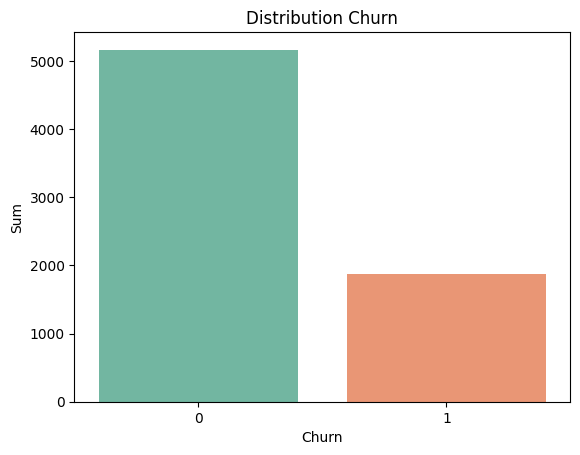


Persentase Churn:
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


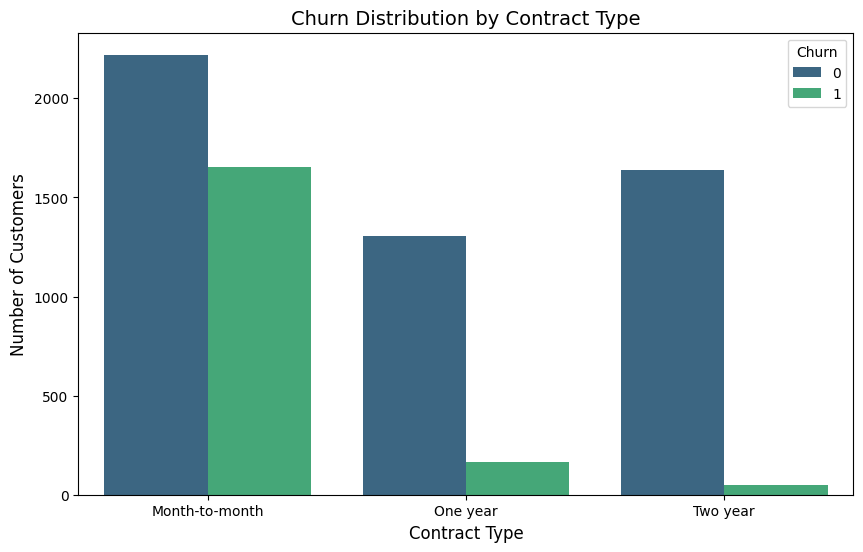

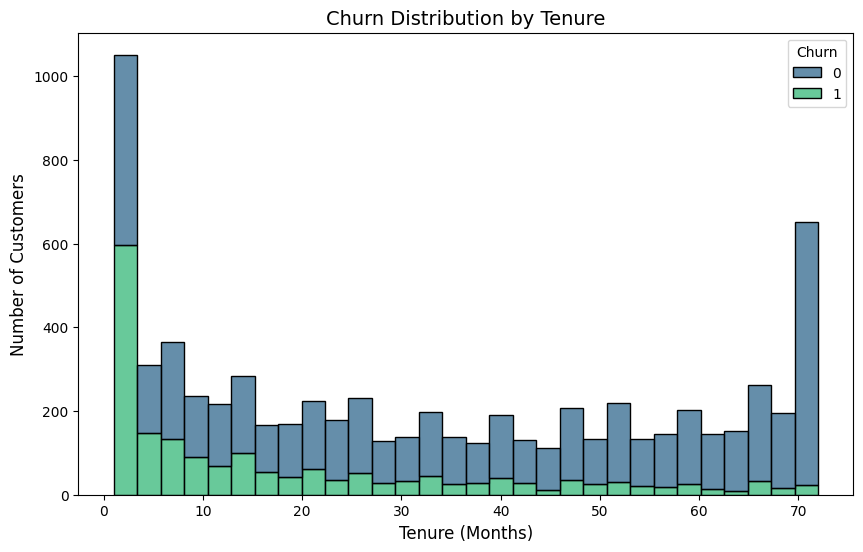

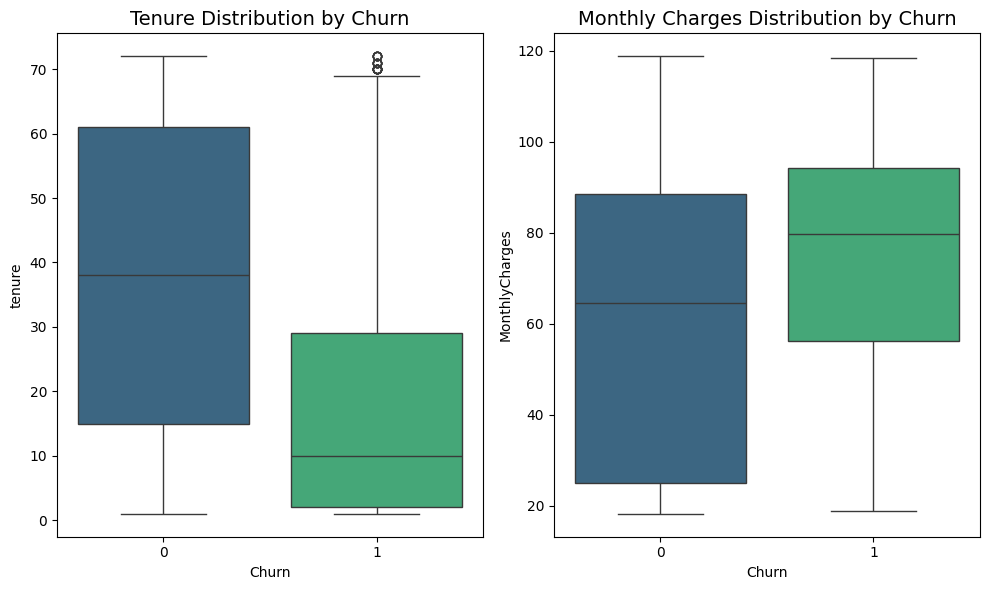

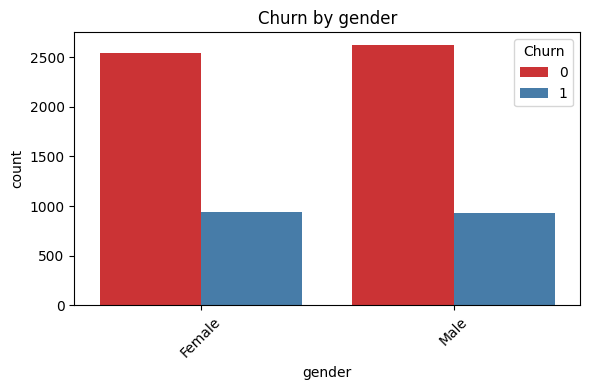

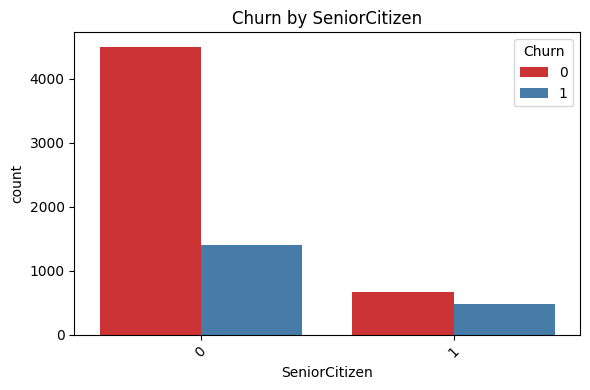

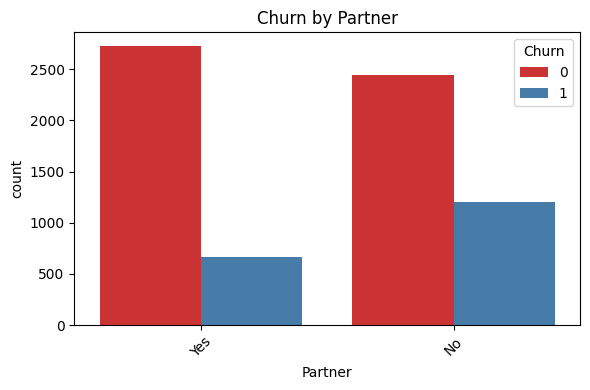

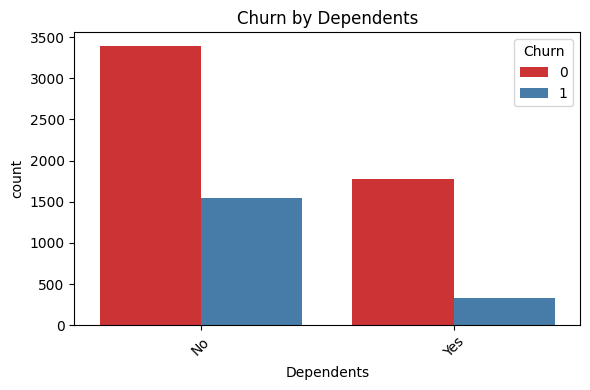

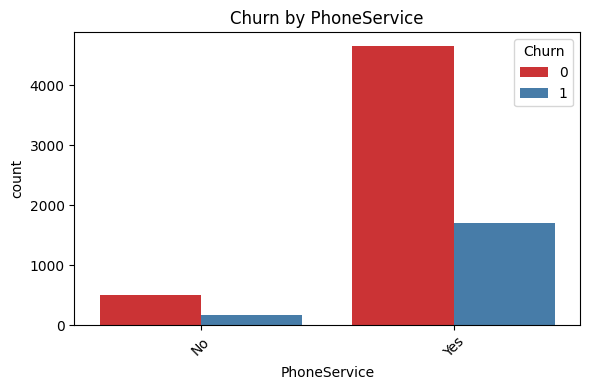

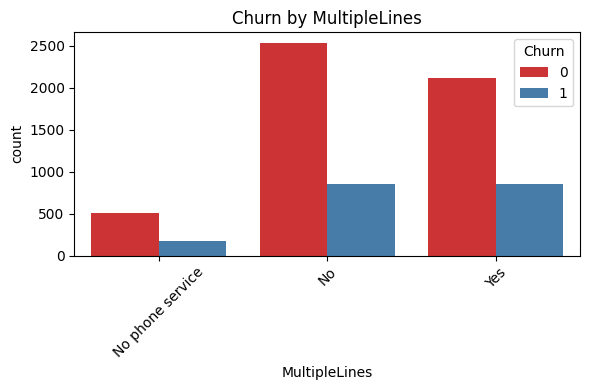

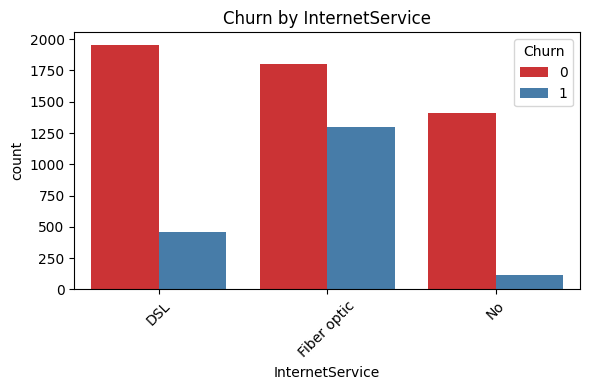

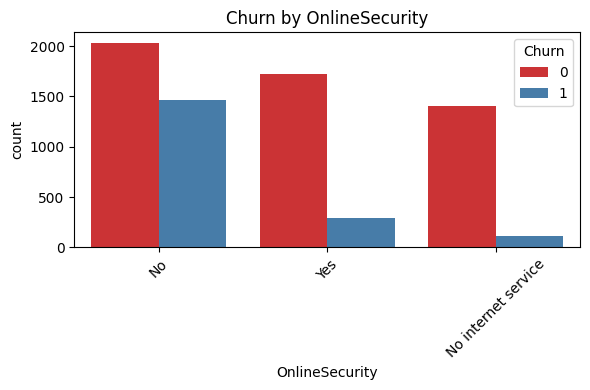

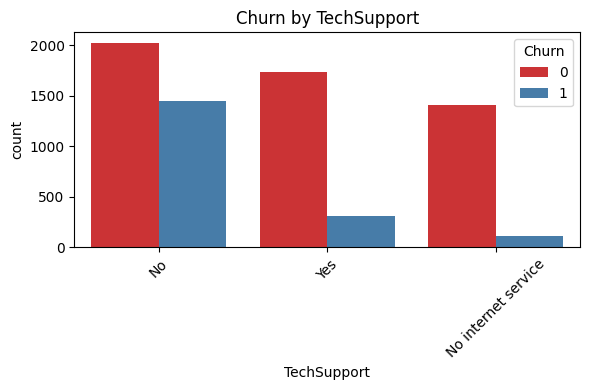

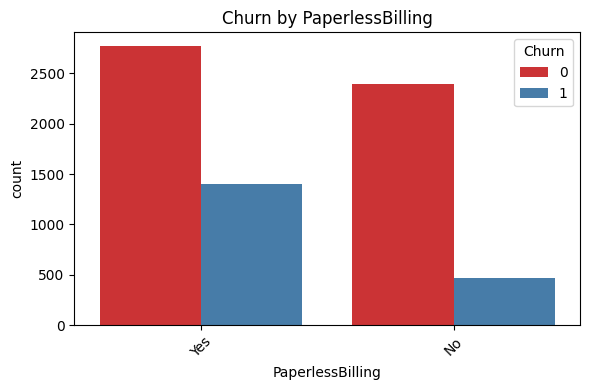

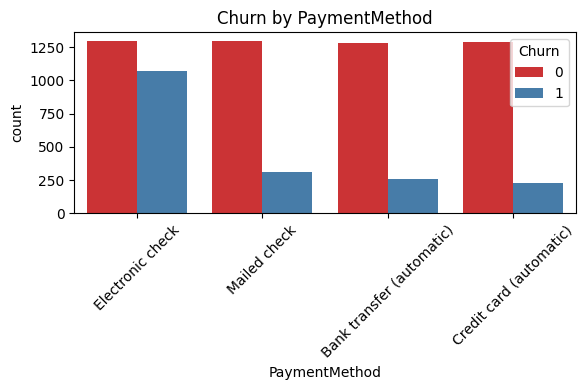

In [4]:
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# Data Overview
print(df.head())
print("\nInfo:")
print(df.info())
print("\nDescriptive Stats:")
print(df.describe(include='all'))

# Convert TotalCharges to numeric and handle errors by setting them to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Convert the target variable 'Churn' to a binary format (1 for 'Yes', 0 for 'No')
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("Data cleaning is complete.")

# Cek Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution Target (Churn)
sns.countplot(data=df, x='Churn', hue='Churn', palette='Set2', legend=False)
plt.title('Distribution Churn')
plt.xlabel('Churn')
plt.ylabel('Sum')
plt.savefig('results/visualizations/eda_distribution_churn.png')
plt.show()
print("\nPersentase Churn:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualize the relationship between Contract type and Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='viridis')
plt.title('Churn Distribution by Contract Type', fontsize=14)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.savefig('results/visualizations/eda_churn_by_contract.png')
plt.show()

# Visualize the relationship between Tenure and Churn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, palette='viridis')
plt.title('Churn Distribution by Tenure', fontsize=14)
plt.xlabel('Tenure (Months)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.savefig('results/visualizations/eda_churn_by_tenure.png')
plt.show()

# Visualize of the boxplot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Churn', y='tenure', data=df, hue='Churn', palette='viridis', legend=False)
plt.title('Tenure Distribution by Churn', fontsize=14)
plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, hue='Churn', palette='viridis', legend=False)
plt.title('Monthly Charges Distribution by Churn', fontsize=14)
plt.tight_layout()
plt.savefig('results/visualizations/eda_tenure&monthlycharges_by_churn.png')
plt.show()

# Churn by Category
def plot_churn_by_feature(feature):
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=feature, hue='Churn', palette='Set1')
    plt.title(f'Churn by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    filename = f'results/visualizations/eda_churn_by_{feature}.png'
    plt.savefig(filename)
    plt.show()
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'TechSupport', 'PaperlessBilling', 'PaymentMethod']
for feature in categorical_features:
    plot_churn_by_feature(feature)

In [5]:
# 5. DATA PREPARATION FOR MODELING
# Separate customerID for the final report BEFORE dropping it
customer_ids = df['customerID']
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical column names
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
print("\nSuccess")


Success


In [6]:
# 6. BUILDING THE PREPROCESSING AND MODEL PIPELINE
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
print("\nSuccess")


Success


In [7]:
# 7. MODEL OPTIMIZATION
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced']
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, n_jobs=-1, scoring='recall')

print("Please Wait")
grid_search.fit(X_train, y_train)
print("\nSuccess")

best_model = grid_search.best_estimator_
print("\nBest parameters found:")
print(grid_search.best_params_)

Please Wait

Success

Best parameters found:
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__n_estimators': 100}


              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1033
           1       0.55      0.72      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.79      0.77      0.78      1407

Confusion Matrix (Test Data):


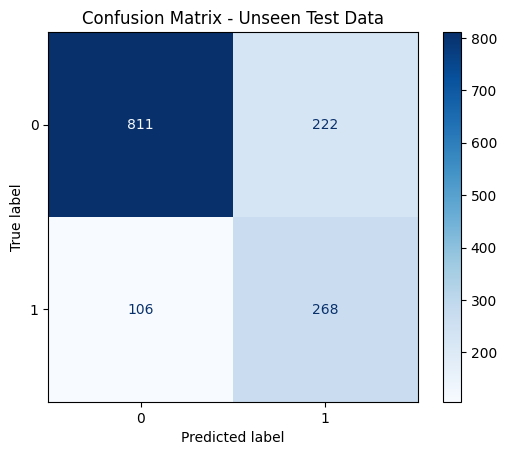

In [8]:
# 8. EVALUATING THE BEST MODEL (ON UNSEEN TEST DATA)
predictions_test = best_model.predict(X_test)
print(classification_report(y_test, predictions_test))

print("Confusion Matrix (Test Data):")
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues', values_format='d')
plt.grid(False)
plt.title('Confusion Matrix - Unseen Test Data')
plt.savefig('results/visualizations/confusion_matrix_test_data.png')
plt.show()

In [10]:
# 9. EXPORTING FINAL RESULTS FOR BUSINESS APPLICATION
full_population_predictions = best_model.predict(X)
full_population_probabilities = best_model.predict_proba(X)[:, 1]
final_results_df = pd.DataFrame({'customerID': customer_ids})
final_results_df = final_results_df.merge(df.rename(columns={'Churn': 'Actual_Churn'}), on='customerID')
final_results_df['Predicted_Churn'] = full_population_predictions
final_results_df['Churn_Probability'] = full_population_probabilities
output_filename = 'results/churn_risk_analysis_recall_optimized.csv'
final_results_df.to_csv(output_filename, index=False)
print(f"\nFile '{output_filename}' has been export.")


File 'results/churn_risk_analysis_recall_optimized.csv' has been export.
